In [1]:
import pickle
from aemulusnu_massfunction.emulator import *
from aemulusnu_massfunction.fisher_utils import *

oup_cov_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/fiducial_cluster_abundance_covariance_nu_mass_%.4f.pkl'%(fiducial_cosmology['nu_mass_ev'])

with open(oup_cov_fname, 'rb') as file:
        cluster_count_cov = pickle.load(file)


loading emulator from /home/users/delon/aemulusnu_massfunction/aemulusnu_massfunction/emulator.pkl


In [2]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]

                
                
from scipy.linalg import cho_factor, cho_solve
cholesky_factor = cho_factor(cov_matrix_2d)
cov_inv = cho_solve(cholesky_factor, np.eye(n_z * n_r))                


In [3]:
# varied = ['10^9 As', 'omch2', 'nu_mass_ev']
varied = list(fiducial_cosmology.keys())

In [4]:
print(fiducial_log10_rel_step_size)

{'10^9 As': -2.6, 'ns': -4, 'H0': -2.3, 'w0': -2.3, 'ombh2': -2.6, 'omch2': -2.3, 'nu_mass_ev': -2.3}


In [5]:
for parameter_changed in varied:
#     print(parameter_changed)
    print('python -u compute_cluster_abundance_at_cosmology.py "%s" %.1f'%(parameter_changed, fiducial_log10_rel_step_size[parameter_changed]))


python -u compute_cluster_abundance_at_cosmology.py "10^9 As" -2.6
python -u compute_cluster_abundance_at_cosmology.py "ns" -4.0
python -u compute_cluster_abundance_at_cosmology.py "H0" -2.3
python -u compute_cluster_abundance_at_cosmology.py "w0" -2.3
python -u compute_cluster_abundance_at_cosmology.py "ombh2" -2.6
python -u compute_cluster_abundance_at_cosmology.py "omch2" -2.3
python -u compute_cluster_abundance_at_cosmology.py "nu_mass_ev" -2.3


In [6]:
dμdθ = {}
dμdθ_unflat = {}

for parameter_changed in varied:
    cluster_abundance_pos = None
    cluster_abundance_neg = None
    log10_rel_step_size = fiducial_log10_rel_step_size[parameter_changed]
    fname_base = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/cluster_abundance_fisher_%s_%.4f_nu_mass_ev_%.4f'%(parameter_changed, log10_rel_step_size, fiducial_cosmology['nu_mass_ev'])

    
    with open(fname_base, 'rb') as file:
        cluster_abundance_pos = pickle.load(file)
    with open(fname_base+'_neg', 'rb') as file:
        cluster_abundance_neg = pickle.load(file)
    h = np.abs(fiducial_cosmology[parameter_changed]) * 10**log10_rel_step_size
    tmp_theory_deriv = (cluster_abundance_pos - cluster_abundance_neg) / (2 * h)
    flattened_theory_deriv = np.zeros((n_z * n_r))
    for i in range(n_z):
        for a in range(n_r):
            flattened_theory_deriv[i * n_r + a] = tmp_theory_deriv[i, a]
    dμdθ[parameter_changed] = flattened_theory_deriv
    dμdθ_unflat[parameter_changed] = tmp_theory_deriv


In [7]:
# N_fiducial = N_in_z_bins_and_richness_bins(fiducial_cosmology, richness_bin_edges, z_bin_edges)
# flattened_N_fid = np.zeros((n_z * n_r))

# for i in range(n_z):
#         for a in range(n_r):
#             flattened_N_fid[i * n_r + a] = N_fiducial[i, a]

In [8]:
labels = {
    '10^9 As': r'$10^9A_s$',
    'ns': r'$n_s$',
    'H0': r'$H_0$',
    'w0': r'$w_0$',
    'ombh2': r'$\Omega_b h^2$',
    'omch2': r'$\Omega_c h^2$',
    'nu_mass_ev': r'$\sum m_\nu$',
    'sigma8' : r'$\sigma_8$'
}

In [9]:
n_parameters = len(varied)

fisher_matrix = np.zeros((n_parameters, n_parameters))

# # adding planck prior 1807.06209 table 2
# Planck_σ = {
#     '10^9 As': 0.029,
#     'ns': 0.0038,
#     'H0': 0.42,
#     'w0': np.inf, #unconstrained by main analysis
#     'ombh2':0.00014,
#     'omch2':0.00091,
#     'nu_mass_ev': np.inf, #unconstrained by main analysis
# }

# adding planck prior mnu 1807.06209 table 5
Planck_σ = {
    '10^9 As': 0.03,
    'ns': 0.0043,
    'H0': 1.2,
    'w0': np.inf, #unconstrained by main analysis
    'ombh2':0.00015,
    'omch2':0.0013,
    'nu_mass_ev': np.inf, #assume nothing
}


nu_mass_ev_idx = -1
for i, θi in enumerate(varied):
    print(i, θi)
    if(θi == 'nu_mass_ev'):
        nu_mass_ev_idx = i
    for j, θj in enumerate(varied):
        dμl_θi = dμdθ[θi]
        dμm_θj = dμdθ[θj]
        fisher_matrix[i,j] = np.einsum('l,lm,m', dμl_θi, cov_inv, dμm_θj)
    fisher_matrix[i,i] += 1/Planck_σ[θi]**2

0 10^9 As
1 ns
2 H0
3 w0
4 ombh2
5 omch2
6 nu_mass_ev


In [10]:
print(fiducial_cosmology)

{'10^9 As': 2.1, 'ns': 0.9649, 'H0': 67.36, 'w0': -1, 'ombh2': 0.02237, 'omch2': 0.12, 'nu_mass_ev': 0.06}


In [11]:
maximized = ['w0']
# maximized = ['10^9 As', 'ns', 'H0', 'w0', 'ombh2', 'omch2']

maximized_idxs = [list(varied).index(c) for c in maximized]

for idx in reversed(sorted(maximized_idxs)):
    fisher_matrix = np.delete(fisher_matrix, idx, axis=0)  
    fisher_matrix = np.delete(fisher_matrix, idx, axis=1) 

    if(nu_mass_ev_idx >= idx):
        nu_mass_ev_idx -= 1

/tmp/ipykernel_9979/3987580144.py:6: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(fisher_matrix), cmap='rainbow')


Text(0.5, 1.0, '$\\log_{10}$Fisher Matrix')

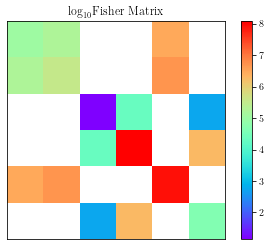

In [12]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 32
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
plt.imshow(np.log10(fisher_matrix), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'$\log_{10}$Fisher Matrix')


In [13]:
from scipy.linalg import cho_solve, cho_factor

# Compute the Cholesky decomposition
cholesky_factor = cho_factor(fisher_matrix)

# Solve for the inverse of the diagonal element
e_i = np.zeros_like(fisher_matrix[nu_mass_ev_idx])
e_i[nu_mass_ev_idx] = 1

inv_diagonal_element = cho_solve(cholesky_factor, e_i)[nu_mass_ev_idx]

In [14]:
inv_diagonal_element

0.004560838542615028

In [15]:
inv_fisher_matrix = np.linalg.inv(fisher_matrix)


np.sqrt(inv_fisher_matrix[nu_mass_ev_idx][nu_mass_ev_idx])

0.06753398065133744

In [16]:
print('%10s\t %25s\t %25s'%('parameter', 'σ(marginalized)/fid val', 'σ(unmarginalized)/fid val'))
print('----------------------------------------------------------------------------')
i=0
for θi in (varied):
    if(θi in maximized):
        continue
    print('%10s\t %25.1e\t %25.1e'%(θi, np.abs(np.sqrt(inv_fisher_matrix[i,i])/fiducial_cosmology[θi]), np.abs(np.sqrt(fisher_matrix[i,i])**(-1)/fiducial_cosmology[θi])))
    i += 1

 parameter	   σ(marginalized)/fid val	 σ(unmarginalized)/fid val
----------------------------------------------------------------------------
   10^9 As	                   1.4e-02	                   1.5e-03
        ns	                   4.2e-03	                   1.7e-03
        H0	                   6.9e-03	                   3.9e-03
     ombh2	                   6.7e-03	                   4.1e-03
     omch2	                   1.0e-02	                   9.1e-04
nu_mass_ev	                   1.1e+00	                   7.7e-02


In [17]:
print('%10s\t %25s'%('parameter', 'fid val +/- σ(marginalized)'))
print('----------------------------------------------------------------------------')
i=0
for θi in (varied):
    if(θi in maximized):
        continue
    print('%10s\t %7.4f +/- %.5f'%(θi, (fiducial_cosmology[θi]),np.sqrt(inv_fisher_matrix[i,i])))
    i += 1

 parameter	 fid val +/- σ(marginalized)
----------------------------------------------------------------------------
   10^9 As	  2.1000 +/- 0.02992
        ns	  0.9649 +/- 0.00406
        H0	 67.3600 +/- 0.46256
     ombh2	  0.0224 +/- 0.00015
     omch2	  0.1200 +/- 0.00124
nu_mass_ev	  0.0600 +/- 0.06753


In [18]:
tinker_cov = None
with open('tinker_forecast/tinker_fisher.pkl', 'rb') as file:
    tinker_cov = pickle.load(file)


In [19]:
plt.show()
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 5


a
c
b
a
c
b


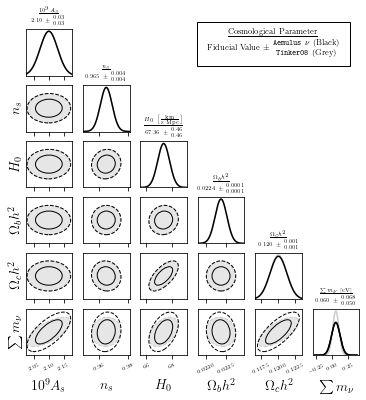

In [20]:
lrot=25
#https://arxiv.org/pdf/0906.4123.pdf
def ellipse_params(curr_cov):
    """Implements (2-4) of Coe's paper"""

    a2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          + np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    b2 = [[(curr_cov[a][a] + curr_cov[b][b])/2 
          - np.sqrt((curr_cov[a][a]-curr_cov[b][b])**2/4 + curr_cov[a][b]**2) 
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    th = [[1/2*np.arctan(2*curr_cov[a][b]/(curr_cov[a][a] - curr_cov[b][b]))*180/np.pi 
           if a != b else -100
           for b in range(len(curr_cov[0]))]
          for a in range(len(curr_cov))]
    
    #fixes mixed up width and heights. 
    #a2[i][j] shouldn't equal a2[j][i] (the scales would be all wrong)
    #but should equal b2[j][i] since the width becomes the height
    #and vice versa. 
    for i in range(len(curr_cov)):
        for j in range(len(curr_cov)):
            if(curr_cov[i][i] < curr_cov[j][j]):
                a2[i][j], b2[i][j] = b2[i][j], a2[i][j]
    return(a2, b2, th)

from matplotlib.patches import Ellipse

fig, ax = plt.subplots(6,6, figsize=(6,6), sharex = 'col', sharey='row',)
import matplotlib.cm as cm
vlower, vupper = [None]*6, [None]*6
for cov_idx, (cov,color) in enumerate(zip([tinker_cov,inv_fisher_matrix ], ['0.8', 'black'])):

    # Get a color from the colormap based on the index
#     color = 'black'

    a2, b2, th = ellipse_params(cov)
    #     print(nu_mass, cov[1,1])

    fid = [fiducial_cosmology['10^9 As'], 
           fiducial_cosmology['ns'],
           fiducial_cosmology['H0'],
           fiducial_cosmology['ombh2'],
           fiducial_cosmology['omch2'],
           fiducial_cosmology['nu_mass_ev']]
    #Table 1. of Coe
    alpha_1 = 1.52
    alpha_2 = 2.48
    alpha = np.array([alpha_1, alpha_2])
    labels = [r'$10^9A_s$', 
              r'$\Sigma m_\nu$',]
    labels = [r'$10^9A_s$',
              r'$n_s$',
              r'$H_0\ \left[\frac{\rm km} {{\rm s}\ {\rm Mpc}} \right]$',
              r'$\Omega_b h^2$',
              r'$\Omega_c h^2$',
              r'$\sum m_\nu$ [eV]',]
    #make cool elipses
    for i in range(len(cov)):
        for j in range(i):
            wdth = np.sqrt(a2[j][i])*alpha*2
            hght = np.sqrt(b2[j][i])*alpha*2

            facecolor ='none'
            if(color == '0.8'):
                facecolor= '0.9'
            sigma_1_ellipse = Ellipse(xy = (fid[j], fid[i]), 
                                        width= wdth[0],
                                        height= hght[0],
                                        angle=th[j][i], ls='-', 
                                        edgecolor=color, 
                                      lw=1, alpha=1,
                                        facecolor=facecolor)
            ax[i][j].add_artist(sigma_1_ellipse)

            sigma_2_ellipse = Ellipse(xy = (fid[j], fid[i]), 
                                        width= wdth[1],
                                        height= hght[1],
                                        angle=th[j][i], ls='--', 
                                        edgecolor=color, lw=1, alpha=1,
                                        facecolor=facecolor)
            ax[i][j].add_artist(sigma_2_ellipse)  
            if(cov_idx == 0):
                ax[i][j].set_xlim([fid[j]-1.3*wdth[0], fid[j]+1.3*wdth[0]])
                ax[i][j].set_ylim([fid[i]-1.3*hght[0], fid[i]+1.3*hght[0]])

            ax[j][i].axis('off')
            space = 2
            if(j==0):
                ax[i][j].set_ylabel(labels[i], fontsize=14)
                if(i == 2):
                    print('a')
                    ax[i][j].set_ylabel(r'$H_0$', fontsize=14)
                if(i == 5):
                    print('c')
                    ax[i][j].set_ylabel(r'$\sum m_\nu$', fontsize=14)
                ax[i][i].get_yaxis().set_label_coords(-0.5,0.5)

            if(i==len(cov)-1):
                ax[i][j].set_xlabel(labels[j], fontsize=14)
                if( j == 2):
                    print('b')
                    ax[i][j].set_xlabel(r'$H_0$', fontsize=14)
                    
                ax[i][j].get_xaxis().set_label_coords(0.5,-0.5)
                ax[i][j].tick_params(axis='x', labelrotation=lrot)
    def gauss(mean, sig, x):
        return 1/np.sqrt(2*np.pi*sig**2)*np.exp(-(x-mean)**2/(2*sig**2)) 
    tmp0, tmp1 = ax[0][0].get_ylim()
    ax[0][0].set_ylim(0, tmp1)
    

    #plot gaussians
    for i in range(len(cov)):

        sig = np.sqrt(cov[i][i])
        x = np.linspace(fid[i]-sig*5, fid[i] + sig*5, 10000)
        # we want to scale so that guassian fit in frame 
        # from what I understand the main thing we want to quantitatively 
        # preserve is the "spread" in x while the 
        # amplitude of the gaussian we can rescale 
        
        
        y = gauss(fid[i], sig,x)
        if(vlower[i] == None):
            vupper[i] = [np.max(y),-1]
            vlower[i] = [0,-1]
            vlower[i][1], vupper[i][1] = ax[i][i].get_ylim()
        lower = vlower[i]
        upper = vupper[i]
        
        scale = (upper[1]-lower[1]) * (np.max(y)/upper[0])
        
        y = lower[1] + .95*scale * y/np.max(y)
#         ax[i][i].axvline(fid[i]-sig, ls='--', color=color)
#         ax[i][i].axvline(fid[i]+sig, ls='--', color=color)
        ax[i][i].plot(x, y, '-', color=color)
    
ax[5][5].set_xlabel(r'$\sum m_\nu$', fontsize=14)
ax[5][5].get_xaxis().set_label_coords(0.5,-0.5)

for i in range(len(cov)):
    sig_tinker = np.sqrt(tinker_cov[i][i])
    sig_aemulus = np.sqrt(inv_fisher_matrix[i][i])

    ax[i][i].plot(x, y, '-', color=color)
    c_txt = r'\underline{%s}'%labels[i] + '\n'+ r'%.3f $\pm\ \begin{matrix} %.3f \\ %.3f \end{matrix}$'%(fid[i], sig_aemulus, sig_tinker)
    if(i==3):
        #omb h2
        c_txt = r'\underline{%s}'%labels[i] + '\n'+ r'%.4f $\pm\ \begin{matrix} %.4f \\ %.4f \end{matrix}$'%( fid[i], sig_aemulus, sig_tinker)
    if(i in [0,2]):
        c_txt = r'\underline{%s}'%labels[i] + '\n'+ r'%.2f $\pm\ \begin{matrix} %.2f \\ %.2f \end{matrix}$'%(fid[i], sig_aemulus, sig_tinker)
    
    ax[i][i].text(0.5, 1.1,
            s=c_txt,
            transform=ax[i][i].transAxes,
            horizontalalignment='center',
            verticalalignment='bottom')
    ax[i][i].set_yticks([])
ax[-1][-1].tick_params(axis='x', labelrotation=lrot)
    
    
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[i][j].set_box_aspect(1)

meta_txt = r'\underline{Cosmological Parameter}' + '\n'+ r'Fiducial Value $\pm\ \begin{matrix}  \textrm{\texttt{Aemulus} $\nu$ (Black)} \\ \textrm{\texttt{Tinker08} (Grey)}  \end{matrix}$'  
fig.text(0.7, .85,
            s=meta_txt,
            horizontalalignment='center',
            verticalalignment='center',
         fontsize=8,
        bbox=dict(facecolor='none', edgecolor='k', pad=10.0))
# leg = plt.legend(title=meta_txt, loc='upper left')
# leg.get_frame().set_edgecolor('k')
# leg.get_frame().set_facecolor('none')
# leg._legend_box.align = "right"

plt.savefig('Planck 2018+HMF.pdf', bbox_inches='tight')